In [395]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import math
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [408]:
TDF = pd.read_csv('TDF_Data.csv')
Pazzo = pd.read_csv('Pazzo_data.csv')
new_data= pd.read_csv("combined_data.csv")
del new_data['prior_dispatch_rate']
new_data = new_data.dropna()
new_data['Date'] = pd.to_datetime(new_data['Date'])
a = new_data.join(pd.get_dummies(new_data['DC']))
del a['DC']
del a['DC East']

465 445
332.2903225806452 248.8808988764045


(array([5.1e+03, 6.3e+01, 8.0e+00, 8.0e+00, 4.0e+00, 4.0e+00, 9.0e+00,
        2.0e+00, 1.0e+00, 1.0e+00]),
 array([   0. ,  574.4, 1148.8, 1723.2, 2297.6, 2872. , 3446.4, 4020.8,
        4595.2, 5169.6, 5744. ]),
 <a list of 10 Patch objects>)

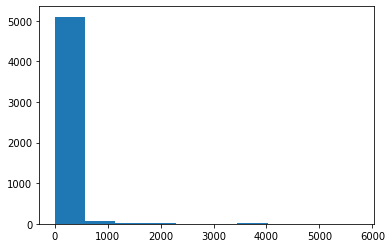

In [346]:
#total cut size and count (east vs west)
TDF['cut_size'] = TDF['Purchase Order Units'] - TDF['Fulfilled Units']

TDFwest = TDF[TDF['DC'] == 'DC West']
TDFeast = TDF[TDF['DC'] == 'DC East']

print(len(TDFeast[TDFeast['cut_size'] != 0]),len(TDFwest[TDFwest['cut_size'] !=0]))
print(np.mean(TDFeast['cut_size'][TDFeast['cut_size'] != 0]),np.mean(TDFwest['cut_size'][TDFwest['cut_size'] != 0]))
# Not much difference in terms of cut count east vs west. But average size of cut significantly higher in east than in west. 

plt.hist(TDF['cut_size'])

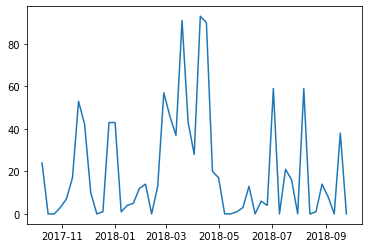

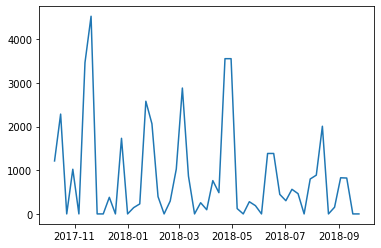

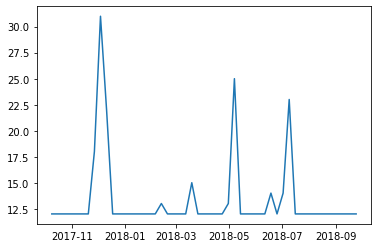

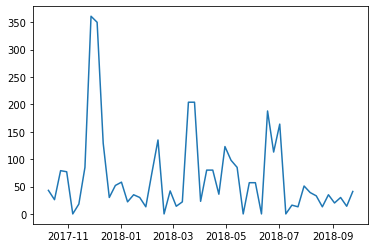

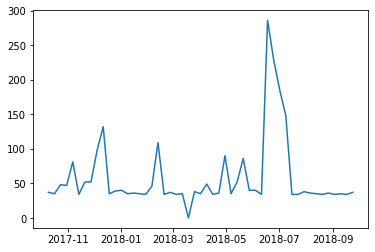

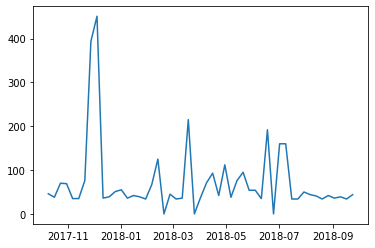

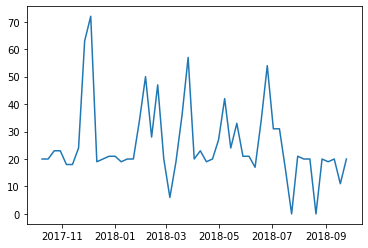

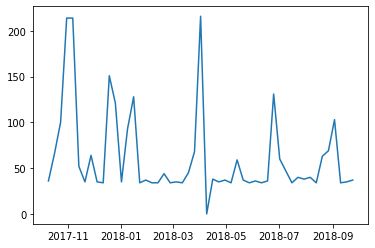

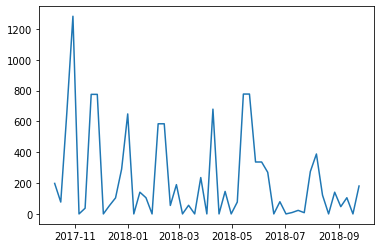

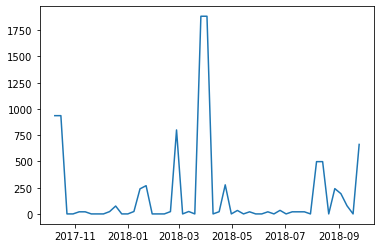

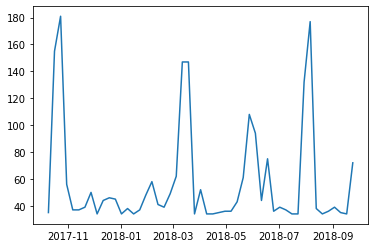

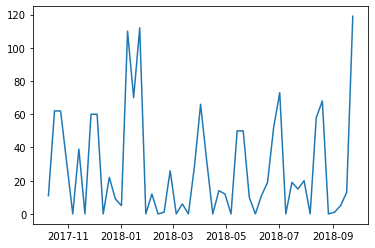

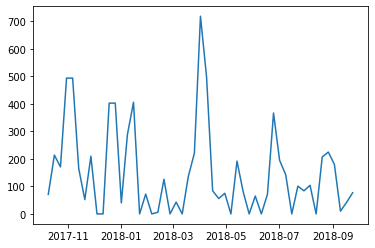

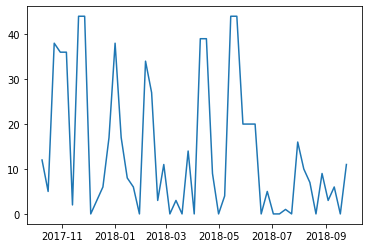

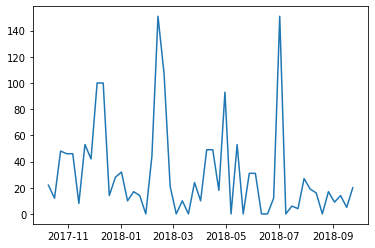

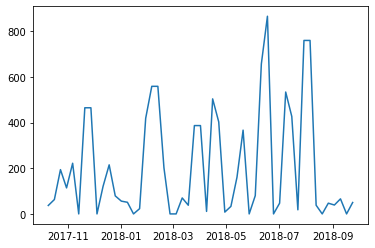

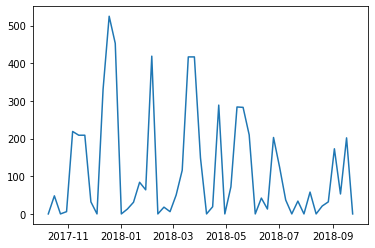

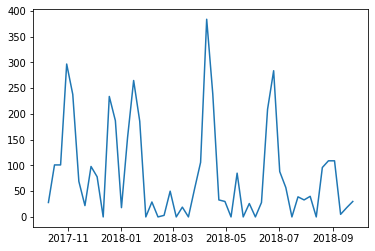

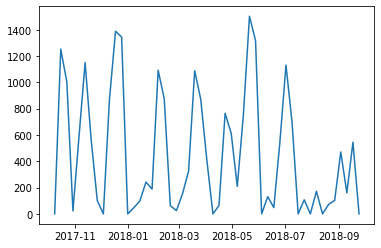

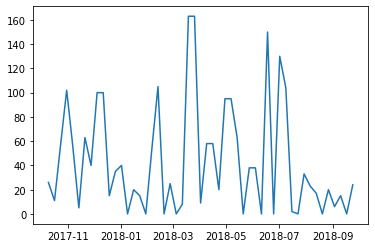

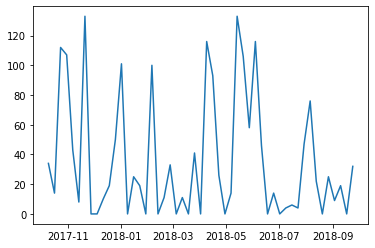

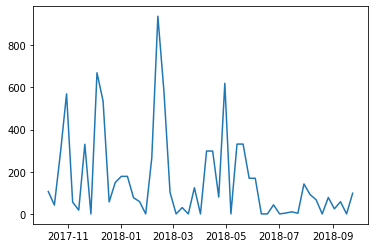

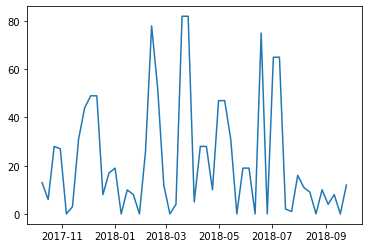

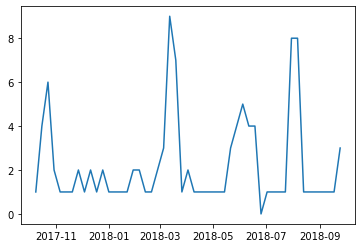

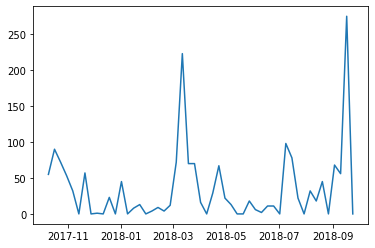

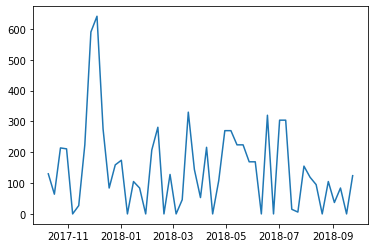

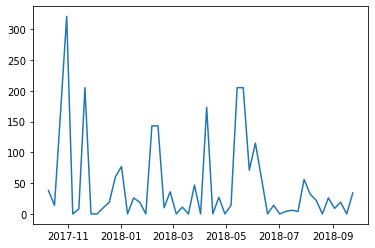

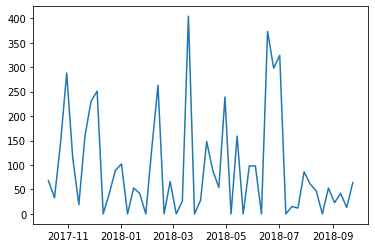

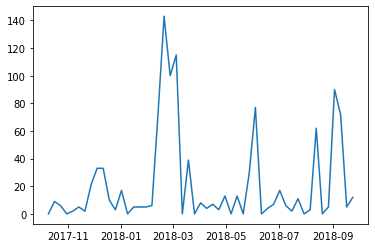

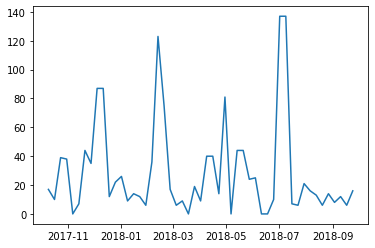

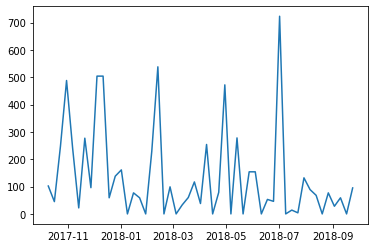

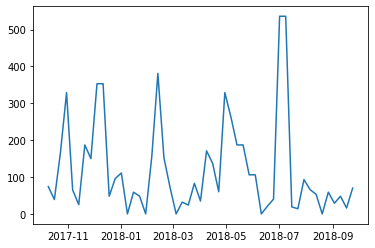

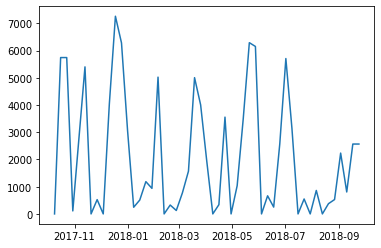

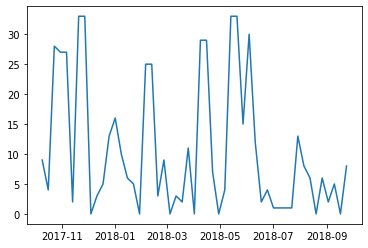

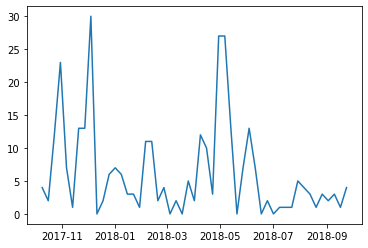

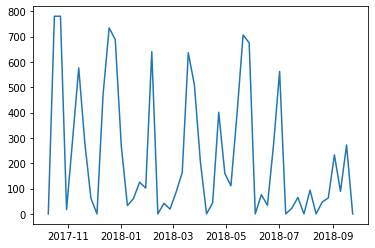

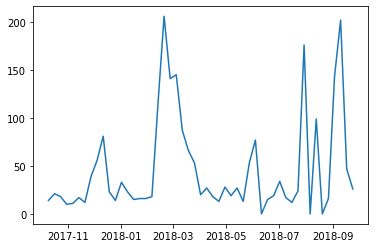

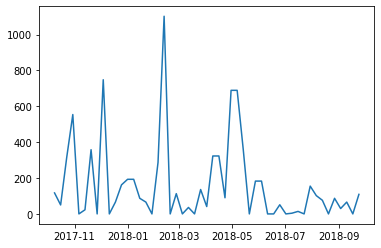

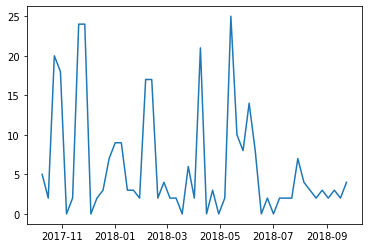

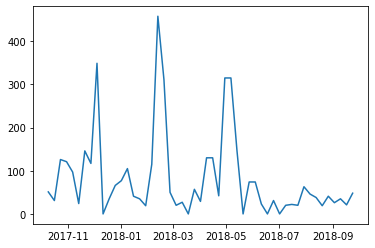

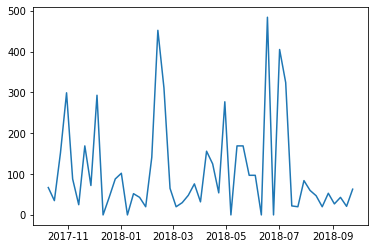

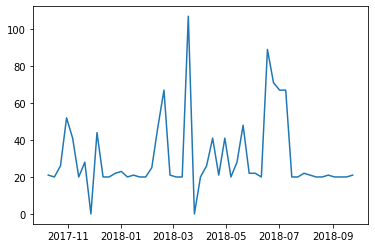

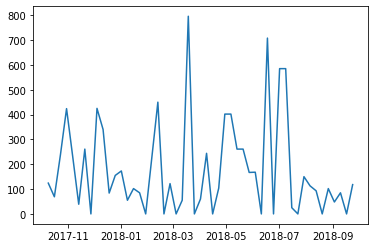

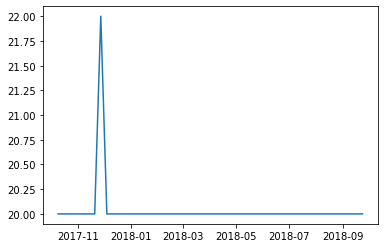

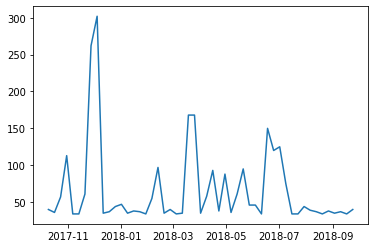

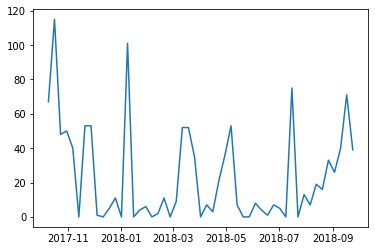

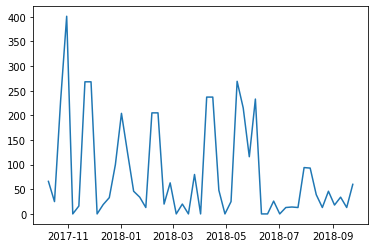

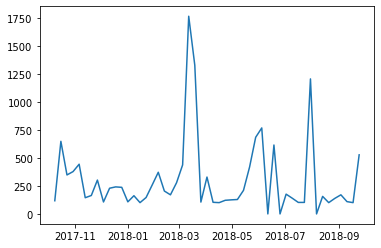

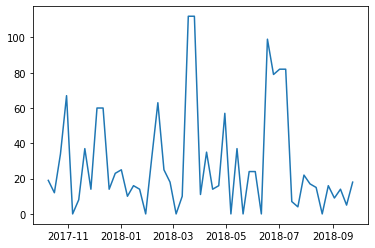

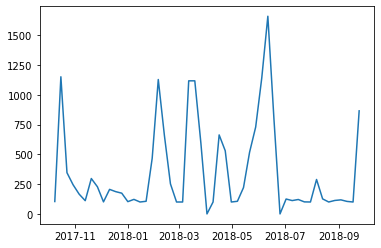

In [347]:
## Time series visualization
## DET freq #? 
def cleanvizwest(data):
    pd.to_datetime(data['Date'])
    westdata = data[data['DC West'] ==1]
    for i in np.unique(westdata['SKU']):
        region_data = westdata[westdata['SKU'] ==i]
        plt.plot(region_data['Date'],region_data['Purchase Order Units'])
        plt.show()
        
def cleanvizeast(data):
    pd.to_datetime(data['Date'])
    eastdata = data[data['DC West'] ==0]
    for i in np.unique(eastdata['SKU']):
        region_data = eastdata[eastdata['SKU'] ==i]
        plt.plot(region_data['Date'],region_data['Purchase Order Units'])
        plt.show()
        
cleanvizeast(a)

SKU001


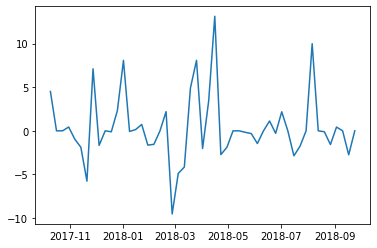

SKU002


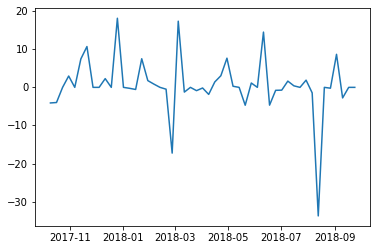

SKU003


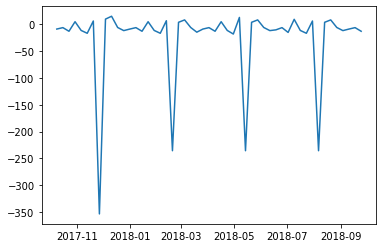

SKU004


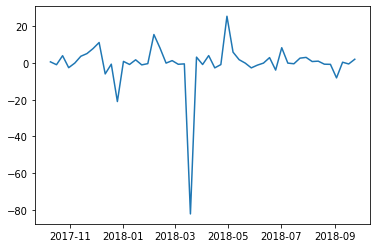

SKU005


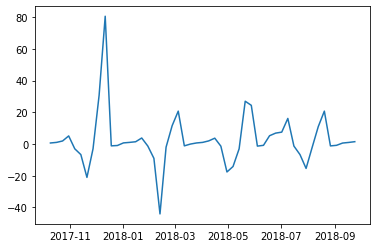

SKU006


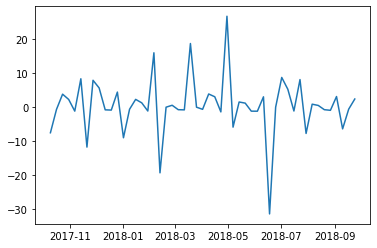

SKU007


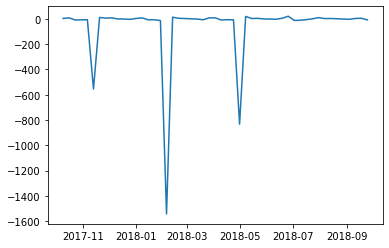

SKU008


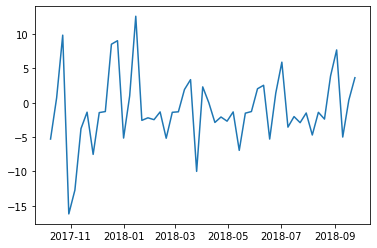

SKU009


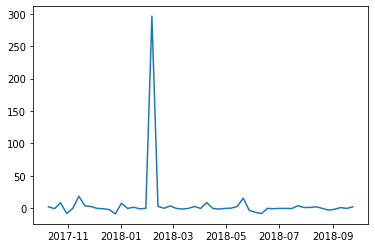

SKU010


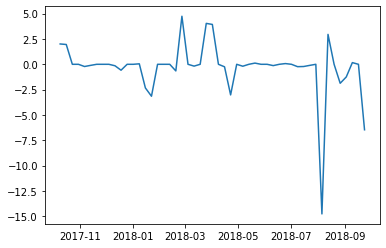

SKU011


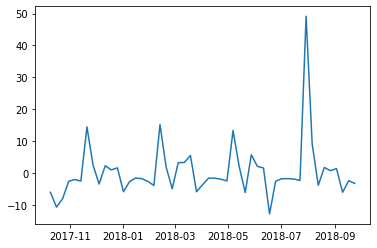

SKU012


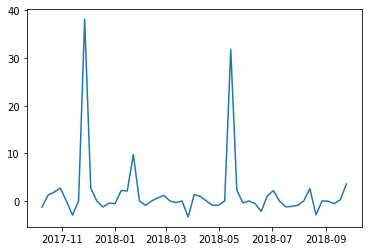

SKU013


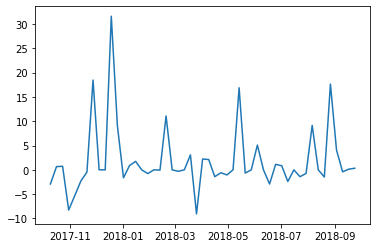

SKU014


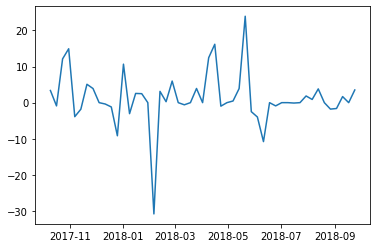

SKU015


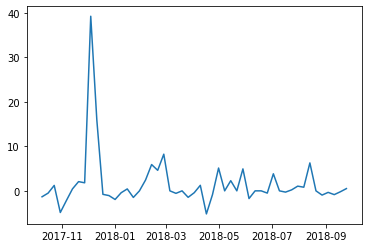

SKU016


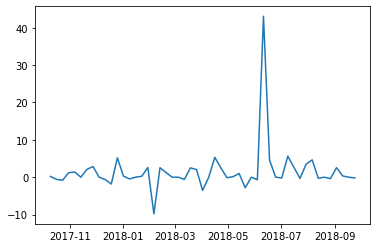

SKU017


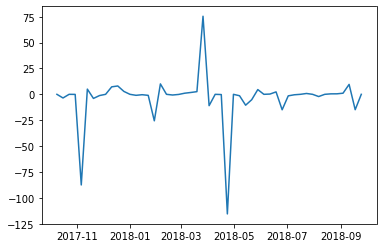

SKU018


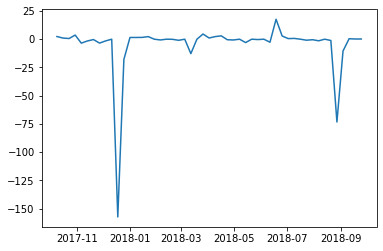

SKU019


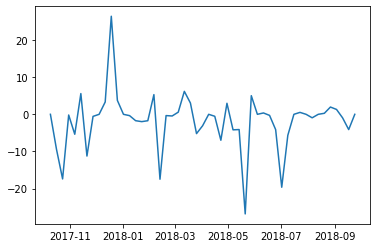

SKU020


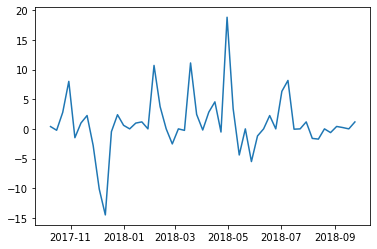

SKU021


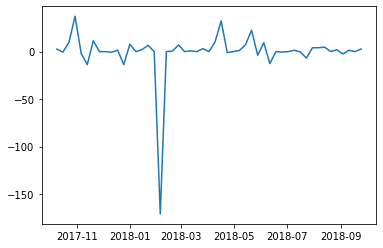

SKU022


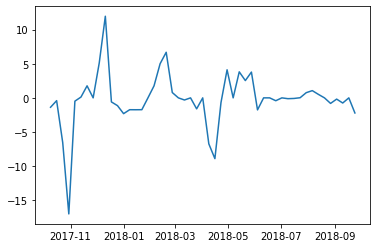

SKU023


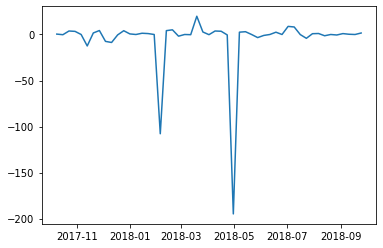

SKU024


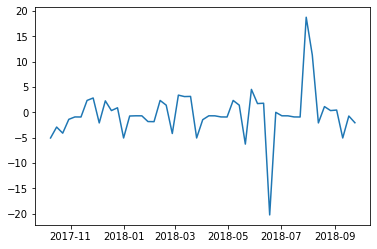

SKU025


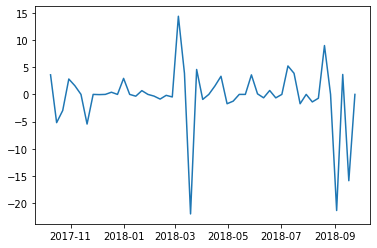

SKU026


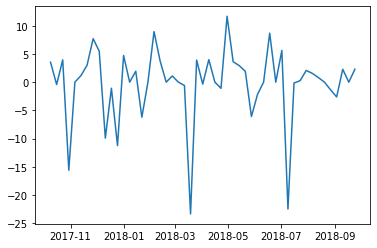

SKU027


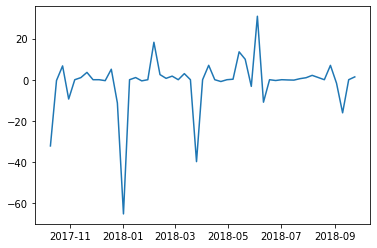

SKU028


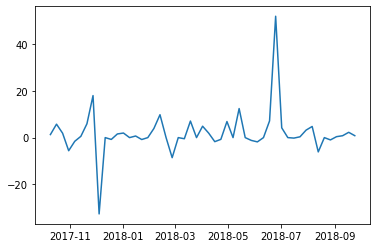

SKU029


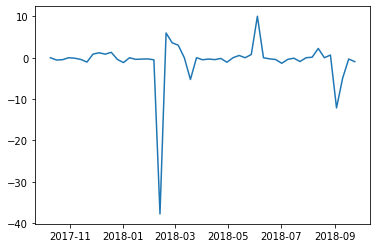

SKU030


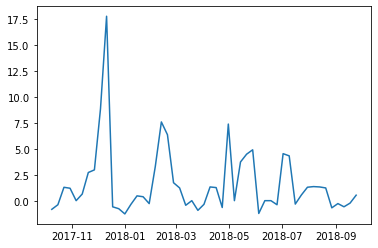

SKU031


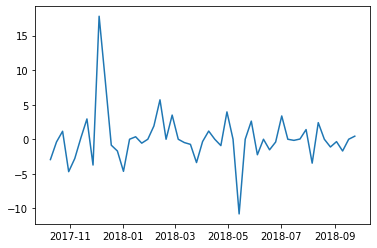

SKU032


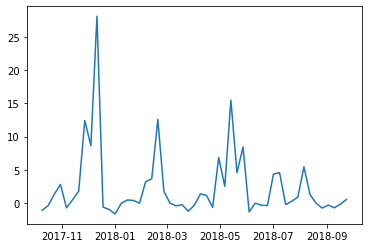

SKU033


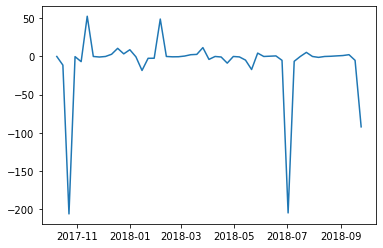

SKU034


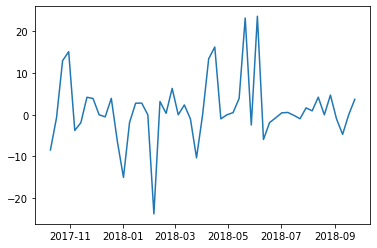

SKU035


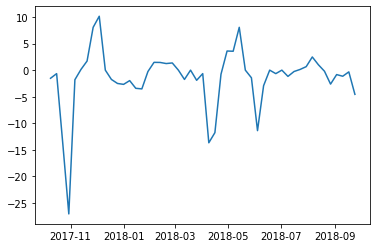

SKU036


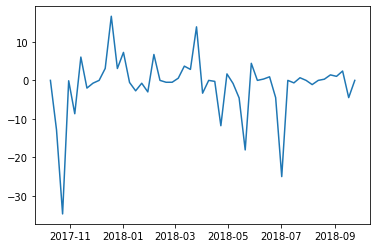

SKU037


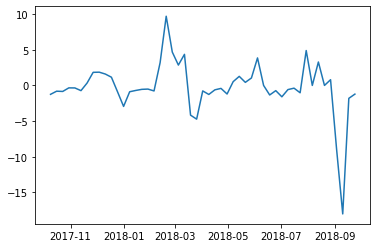

SKU038


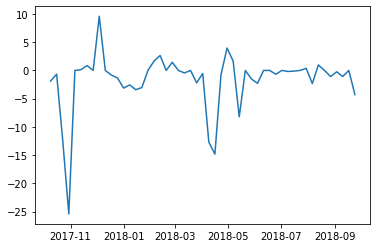

SKU039


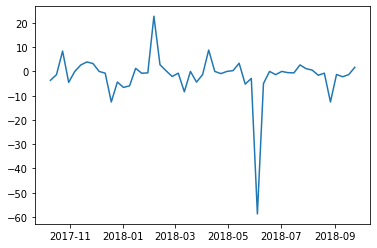

SKU040


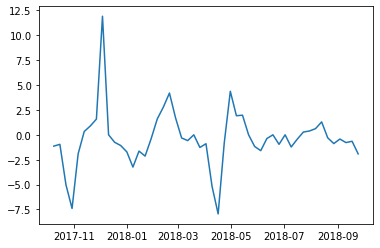

SKU041


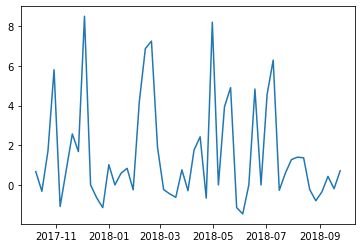

SKU042


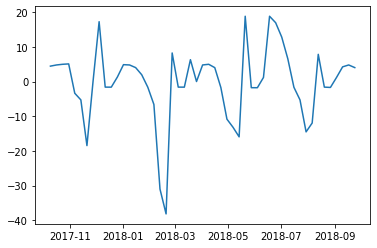

SKU043


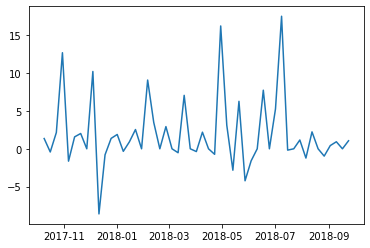

SKU044


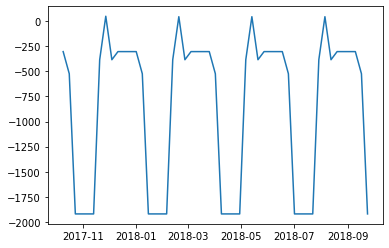

SKU045


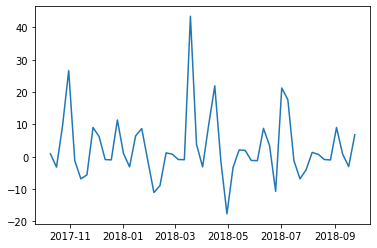

SKU046


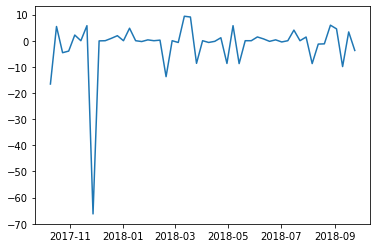

SKU047


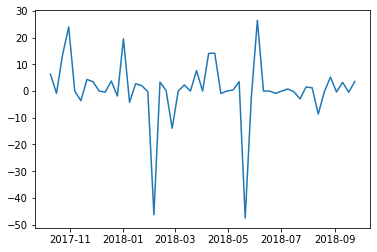

SKU048


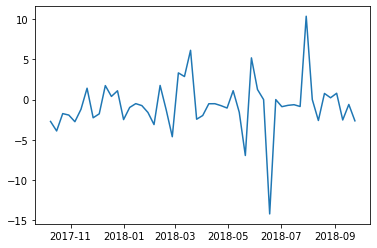

SKU049


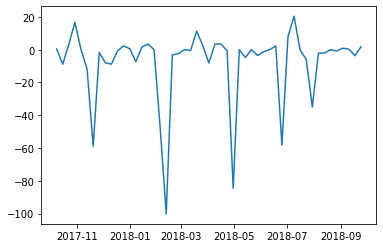

SKU050


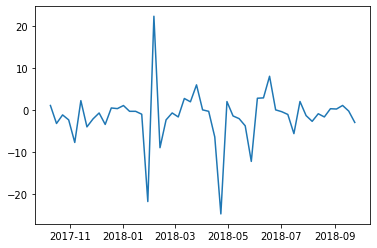

In [348]:
## Deseasonalized visualization
def westseason(data):
    from statsmodels.tsa.seasonal import seasonal_decompose
    pd.to_datetime(data['Date'])
    westdata = data[data['DC West'] ==1]
    for i in np.unique(westdata['SKU']):
        region_data = westdata[westdata['SKU'] ==i]
        result_mul = seasonal_decompose(region_data['Purchase Order Units'], model='additive', freq= 12)
        deseasonalized = region_data['Purchase Order Units'].values / result_mul.seasonal
        plt.plot(deseasonalized)
        plt.show()

def eastseason(data):
    from statsmodels.tsa.seasonal import seasonal_decompose
    pd.to_datetime(data['Date'])
    eastdata = data[data['DC West'] == 0]
    for i in np.unique(eastdata['SKU']):
        region_data = eastdata[eastdata['SKU'] ==i]
        result_mul = seasonal_decompose(region_data['Purchase Order Units'], model='additive', freq= 12)
        deseasonalized = region_data['Purchase Order Units'].values / result_mul.seasonal
        print(i)
        plt.plot(region_data['Date'],deseasonalized)
        plt.show()
        
        
eastseason(a)

In [349]:
# Detrend by difference: 
def westrend(data):
    pd.to_datetime(data['Date'])
    westdata = data[data['DC West'] == 1]
    for i in np.unique(westdata['SKU']):
        region_data = westdata[westdata['SKU'] ==i]
        diff= []
        for k in range(1,len(region_data)):
            vaal = region_data['Purchase Order Units'].iloc[k] - region_data['Purchase Order Units'].iloc[k-1]
            diff.append(vaal)
        print(i)
        plt.plot(region_data['Date'][1:], diff)
        plt.show()

def eastrend(data):
    pd.to_datetime(data['Date'])
    eastdata= data[data['DC West'] == 0]
    for i in np.unique(eastdata['SKU']):
        region_data = eastdata[eastdata['SKU'] == i]
        diff=[]
        for k in range(1, len(region_data)):
            vaal = region_data['Purchase Order Units'].iloc[k] - region_data['Purchase Order Units'].iloc[k-1]
            diff.append(vaal)
        print(i)
        plt.plot(region_data['Date'][1:], diff)
        plt.show()
            
            #         plt.plot(region_data['Date'].iloc[1:],diff,)
#         plt.show()
#         plt.plot(region_data['Date'].iloc[1:],diff)
#         plt.show()

In [350]:
a['prior_cut_size'] = a['Purchase Order Units'] - a['Fulfilled Units']

wrong  = a[a['prior_cut_size'] != 0]
from sklearn.linear_model import LinearRegression
cols = ['On Hand Inventory', 'Pageview Out of Stock','Average Price', 'Consumer Ordered Units', 'Forecast 1 Week','Forecast 4 Week', 'Forecast 8 Week']

X_train, X_test, y_train, y_test = train_test_split(wrong[cols], wrong['Purchase Order Units'], test_size=0.3, random_state=42)
lm = LinearRegression().fit(X_train, y_train)
y_predict = lm.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Test Variance Score:', metrics.r2_score(y_test,y_predict))

Mean Absolute Error: 296.63899021042965
Mean Squared Error: 291965.2442471771
Root Mean Squared Error: 540.338083284139
Test Variance Score: 0.6592695771222821


In [354]:
west_data = a[a['DC West']== 1]

176.31411764705882 164.44466248037676 281.7923581628715
(0.28627450980392155, -28.690698407159136, 28.690698407159136) (0.25353218210361067, -33.67983634413664, 33.67983634413664) (0.46507140100347355, -57.57535660633338, 57.57535660633338)


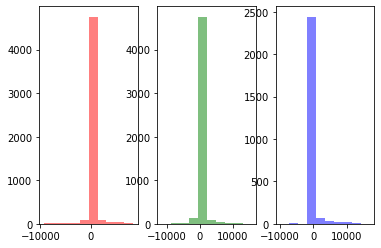

In [335]:
#How accurate is Pazzo prediction
w1_diff = []

for i in range(len(a)):
    if i < 5100:
        w1_diff.append(a['Forecast 1 Week'].iloc[i] - a['Consumer Ordered Units'].iloc[i])

w4_diff = []
for i in range(len(a)):
    if i + 4 < 5100:
        w4_diff.append(a['Forecast 4 Week'].iloc[i] - a['Consumer Ordered Units'].iloc[i+4]) 


w8_diff = [] 
for i in range(len(a)):
    if i+8 < 2599:
        w8_diff.append(a['Forecast 8 Week'].iloc[i] - a['Consumer Ordered Units'].iloc[i+8])

print(np.mean(w1_diff), np.mean(w4_diff), np.mean(w8_diff))
fig, ax = plt.subplots(1,3)
ax[0].hist(w1_diff, alpha = 0.5, color = 'r')
ax[1].hist(w4_diff, alpha = 0.5, color = 'g')
ax[2].hist(w8_diff, alpha=0.5, color='b')

def mean_confidence_interval(data, confidence):
    se = stat.sem(data)
    h = se * stat.t.ppf((1 + confidence) / 2., len(data)-1)
    Low_b = -h
    Up_b = h
    in_conf = []
    for i in data: 
        if i >= Low_b and i <= Up_b:
            in_conf.append(i)
    prop = len(in_conf)/len(data)
    return (prop, Low_b, Up_b)


print(mean_confidence_interval(w1_diff, 0.95), mean_confidence_interval(w4_diff, 0.95), mean_confidence_interval(w8_diff, 0.95))
# week4 most accurate

In [357]:
for i in np.unique(west_data['prior_cut_size']):
    if i !=0:
        west_data['prior_cut_size'] = west_data['prior_cut_size'].replace(i, 1)


C:\Users\bajae\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [375]:
west_data['prior_cut_size'].value_counts()

0    2109
1     441
Name: prior_cut_size, dtype: int64

In [378]:

cols = ['On Hand Inventory', 'Pageview Out of Stock','Average Price', 'Consumer Ordered Units', 'Forecast 1 Week','Forecast 4 Week', 'Forecast 8 Week']
X_train, X_test, y_train, y_test = train_test_split(west_data[cols], west_data['prior_cut_size'], test_size=0.33, random_state=42)
log = LogisticRegression().fit(X_train, y_train)
log.predict(X_test)
score = log.score(X_test, y_test)
print(score)

0.8396674584323041


C:\Users\bajae\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [405]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate = learning_rate, max_features=6, max_depth = 3, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    tn, fp, fn, tp = confusion_matrix(y_test, gb.predict(X_test)).ravel() 
    print(gb.predict(X_test))
    print(tn, fp, fn, tp)

Learning rate:  0.05
Accuracy score (training): 0.827
Accuracy score (validation): 0.838
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

Learning rate:  1
Accuracy score (training): 0.995
Accuracy score (validation): 0.726
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1

In [397]:
tn, fp, fn, tp = confusion_matrix(y_test, gb.predict(X_test)).ravel()